# Age and Gender disparity in Hollywood
 
## Abstract
We have heared again and again that hollywood is biased against women, older women and non whites. However, as not many of the actors in hollywood are willing to share their financial statements, there is little to no hard evidenve to this claim, apart from anecdotal claims made by female actors themselves. As we have been working with publically available movies' financial data for some time, we wondered whether we can quantify these claims in any substantial way, backed by hard numbers.

In the follwoing, we clearly show that women are grossly underpaid for their performances when compared to men.

## Caveates
Our analysis is limited to Oscar nominated actors / actresses, which represents the top tier of hollywood talents. 
- We only take into account Oscar nominations from 1980 to 2014
- For each nominated actor/actress we consider all of their movies from 1995 for which we were able to find financial information
- We might still be missing some data, and will update if necessary

If you are not fluent in python or statistics, you can ignore the code sprinkled in between and just focus on the text and accompanying graphs. Otherwise, feel free to download the data and code from https://github.com/vaultml/oscars

To begin, let us first load our data:

In [26]:
%pylab inline

import pandas as pd
import numpy as np
import data
from data import award

plt.style.use('ggplot')

movies = data.read_movies()
nominations = data.read_awards()
talents = data.read_talents()
roles = data.read_roles()

Populating the interactive namespace from numpy and matplotlib


We begin by flexing our muscles and first looking at the age distribution for nomiations.

In [27]:
def nomination_ages(awards=[award.best_actor], kinds=['W', 'N']):
    noms = nominations.query('award in ' + str(awards) + 'and kind in ' + str(kinds))
    data = []
    for row in noms.itertuples():
        talentid = row.talentid
        talent = talents.query('talentid == "{}"'.format(talentid))
        if len(talent) == 0:
            continue
        year = row.year
        birth_year = talent.iloc[0].birth_date.year
        data.append(year - birth_year)
        
    return data    

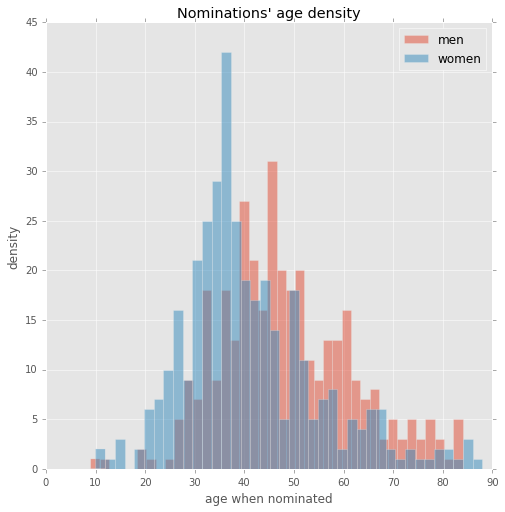

In [32]:
men = nomination_ages(awards=[award.best_actor, award.support_actor], kinds=['W', 'N'])
women = nomination_ages(awards=[award.best_actress, award.support_actress], kinds=['W', 'N'])
plt.figure(figsize=(8, 8))
plt.hist(men, label='men', bins=40, alpha=0.5)
plt.hist(women, label='women', bins=40, alpha=0.5)
plt.xlabel('age when nominated')
plt.ylabel('density')
plt.title("Nominations' age density")
plt.legend()


Several facts jump out immediately. It is really easy to see that women get nominated when they are younger than men. After turning 45, your chances as a women to be nominated goes down steeply. This is not the case for men, where their nomination are concentrated around the ages 35 to 65.

And what is the small blip around the age 10? For the men, it is [Justin Henry](http://www.imdb.com/name/nm0377888/) who was nominated at the age of 8 as best supporting actor for [Kramer vs. Kramer](http://www.imdb.com/title/tt0079417). In the women department we have:
- [Keisha Castle-Hughes](http://www.imdb.com/name/nm1095720/) at the age of 12 for [Whale Rider](http://www.imdb.com/title/tt0298228)
- [Saoirse Ronan](http://www.imdb.com/name/nm1519680/) at ther age of 14 for [Atonement](http://www.imdb.com/title/tt0783233)
- [Hailee Steinfeld ](http://www.imdb.com/name/nm2794962/) at the age of 15 for [True Grit](http://www.imdb.com/title/tt1403865)
- [Quvenzhané Wallis](http://www.imdb.com/name/nm4832920/) at the age of 10 for [Beasts of the Southern Wild](http://www.imdb.com/title/tt2125435)
- [ Anna Paquin ](http://www.imdb.com/name/nm0001593/) at the age of 12 for [The Piano](http://www.imdb.com/title/tt0107822)
- [Abigail Breslin](http://www.imdb.com/name/nm1113550/) at the age of 10 for [Little Miss Sunshine](http://www.imdb.com/title/tt0449059) 

So, let us look only at the winners:

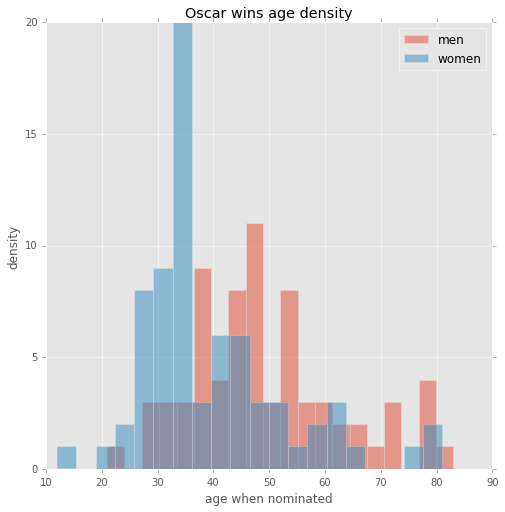

In [31]:
men = nomination_ages(awards=[award.best_actor, award.support_actor], kinds=['W'])
women = nomination_ages(awards=[award.best_actress, award.support_actress], kinds=['W'])
plt.figure(figsize=(8, 8))
plt.hist(men, label='men', bins=20, alpha=0.5)
plt.hist(women, label='women', bins=20, alpha=0.5)
plt.xlabel('age when nominated')
plt.ylabel('density')
plt.title('Oscar wins age density')
plt.legend()


This is much more drastic. If you are a woman above 45, your chances of winning an Oscar are very slim. For men, the distribution of ages is much more uniform from the age of 30 onwards.

Clearly, the academy members show age bias towards women, which is not there towards men.

# Compensation

Another common assumption is that winning (or being nominated to) an Oscar bumps up actors' salaries. Alas, we do not have any access to the financial statements of each and every actor, so we will have to use a proxy; namely, when an actor stars in a movie, the actor's salary is closely correlated with the movie's budget, e.g., the higher the budget, the higher the actor's salary.

So, how does getting nominated affects the budgets of the movies an actor performs in? To illustrate the data, for every year $t$ before and after being nominated, we find the median budget for all movies in which a starring actor was first nominated $t$ year ago (or in $t$ years).

In [35]:
def career_data(award_kinds=[award.best_actor, award.support_actor], target='budget', range=(-10, 10), role='actor', group=True):
    noms = nominations.query('award in ' + str(award_kinds))
    first_nom_years = noms.groupby('talentid').min()
    data = []
    for row in first_nom_years.itertuples():
        talentid = row.Index
        first_nom_year = row.year
        talent_movies = roles.query('talentid == "{}" and role == "{}"'.format(talentid, role))['imdbid']
        talent_movies = movies[movies.imdbid.isin(talent_movies)].copy()
        talent_movies['target'] = talent_movies.eval(target)
        talent_movies['diff'] = talent_movies.eval('year - {}'.format(first_nom_year))
        data.append(talent_movies[['diff', 'target']])
        
    data = pd.concat(data)
    data = data.query('diff >= {} and diff <= {}'.format(*range))
    if not group:
        return data
    data = data.groupby('diff').median()
    return data.rolling(center=False,window=2,axis=0, win_type='triang').mean()
    
    

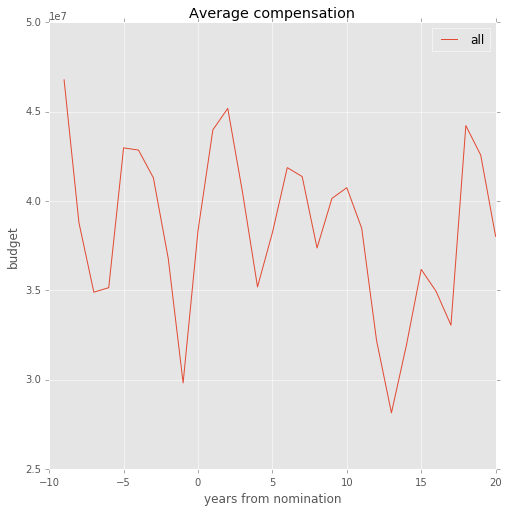

In [39]:
all = career_data(award_kinds=award.acting, target='budget', range=(-10, 20))
plt.figure(figsize=(8, 8))
plt.plot(all.index, all.target, label='all')
plt.xlabel('years from nomination')
plt.ylabel('budget')
plt.title('Average compensation')
plt.legend()

Nothing definite here. A slight bump after being nominated. Let us look at the movies' gross:

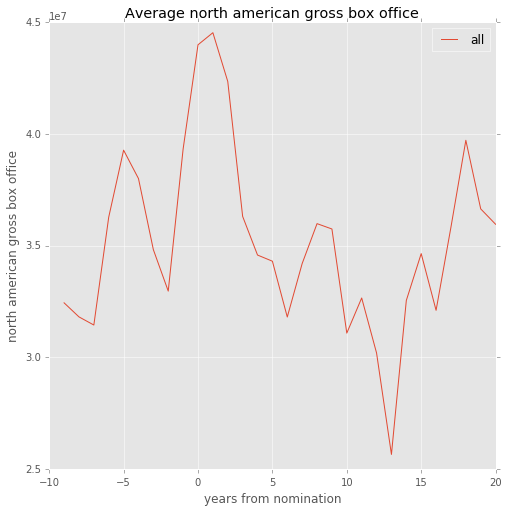

In [40]:
all = career_data(award_kinds=award.acting, target='gross_usa', range=(-10, 20))
plt.figure(figsize=(8, 8))
plt.plot(all.index, all.target, label='all')
plt.xlabel('years from nomination')
plt.ylabel('north american gross box office')
plt.title('Average north american gross box office')
plt.legend()

This is getting interesting! As we can see, there is a sharp rise in the movies' gross income in the years right after the actors' nomination. However, this rise quickly turns into a sharp fall, and the statistics return to the years before the nomination. 

To further investigate the data, let us check if there is a difference between men and women:

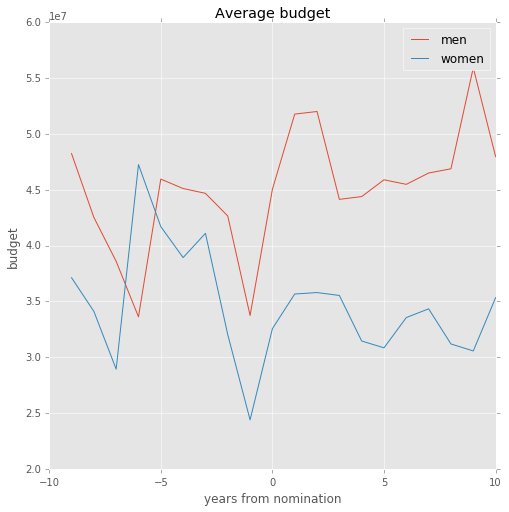

In [41]:
men = career_data(award_kinds=[award.best_actor, award.support_actor], target='budget')
women = career_data(award_kinds=[award.best_actress, award.support_actress], target='budget')

plt.figure(figsize=(8, 8))
plt.plot(men.index, men.target, label='men')
plt.plot(women.index, women.target, label='women')
plt.xlabel('years from nomination')
plt.ylabel('budget')
plt.title('Average budget')
plt.legend()

Clearly, men benefit greatly from being nominated, while there is almost no effect on women. Moreover, this graph clearly depicts the compensation disparity between men and women.

Now, what about the gross?

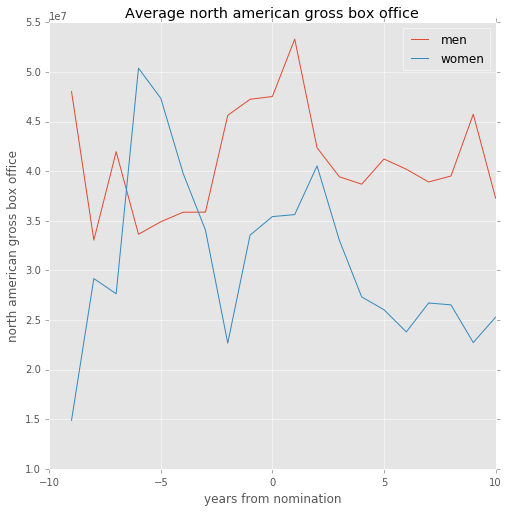

In [44]:
men = career_data(award_kinds=[award.best_actor, award.support_actor], target='gross_usa')
women = career_data(award_kinds=[award.best_actress, award.support_actress], target='gross_usa')

plt.figure(figsize=(8, 8))
plt.plot(men.index, men.target, label='men')
plt.plot(women.index, women.target, label='women')
plt.xlabel('years from nomination')
plt.ylabel('north american gross box office')
plt.title('Average north american gross box office')
plt.legend()

Again, men get a much noticalbe bump in their movies' gross income after being nominated. Moreover, there is also a sharp decline for women 3 years after being nominated, while men's gross returns to its average from before being nominated. 

What would happen if we won't limit ourselves to the first nomiation? Let us look at each nomination as a single event, and inspect the average career in light of every nomination. We start with budgets:

In [46]:
def all_career_data(award_kinds=award.acting, target='budget', range=(-10, 10), role='actor'):
    noms = nominations.query('award in ' + str(award_kinds))
    data = []
    for row in noms.itertuples():
        talentid = row.talentid
        year = row.year
        talent_movies = roles.query('talentid == "{}" and role == "{}"'.format(talentid, role))['imdbid']
        talent_movies = movies[movies.imdbid.isin(talent_movies)].copy()
        talent_movies['target'] = talent_movies.eval(target)
        talent_movies['diff'] = talent_movies.eval('year - {}'.format(year))
        talent_movies['talentid'] = talentid
        data.append(talent_movies[['diff', 'target', 'talentid']])
        
    data = pd.concat(data)
    data = data.query('diff >= {} and diff <= {}'.format(*range))
    data = data.groupby('diff').median()
    return data

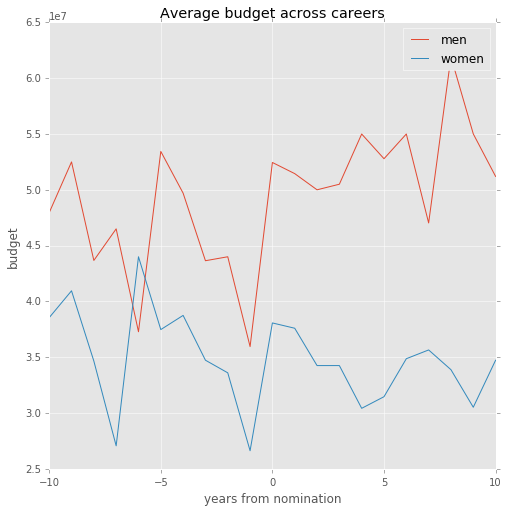

In [47]:
men = all_career_data(award_kinds=[award.best_actor, award.support_actor], target='budget')
women = all_career_data(award_kinds=[award.best_actress, award.support_actress], target='budget')
plt.figure(figsize=(8, 8))
plt.plot(men.index, men.target, label='men')
plt.plot(women.index, women.target, label='women')
plt.xlabel('years from nomination')
plt.ylabel('budget')
plt.title('Average budget across careers')
plt.legend()

Again, a clear difference between men and women. moreover, we see that men's compensation picks up significantly after their nomination, while women's career not at all. What about the gross?

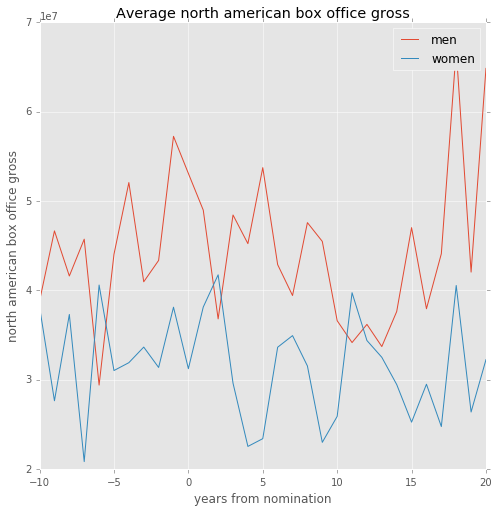

In [48]:
men = all_career_data(award_kinds=[award.best_actor, award.support_actor], target='gross_usa', range=(-10, 20))
women = all_career_data(award_kinds=[award.best_actress, award.support_actress], target='gross_usa', range=(-10, 20))
plt.figure(figsize=(8, 8))
plt.plot(men.index, men.target, label='men')
plt.plot(women.index, women.target, label='women')
plt.xlabel('years from nomination')
plt.ylabel('north american box office gross')
plt.title('Average north american box office gross')
plt.legend()

Again, women careers get a noticable boost after being nominated, but dip spectacularly after 5 years. With men the decline takes aroung 10 years, but ends with a sharp upwards spike.

# Age

What would happen when we pivot the data according to age? We only consider movies in which appeared an actor / actress which were nominated to an Oscar (not neccesarily in this same movie). This represents the age related performance of Oscar nominated actors.

In [20]:
def age_data(gender=['M', 'F'], target='budget', role='actor'):
    target_talents = talents[talents.gender.isin(gender)]
    data = []
    for row in target_talents.itertuples():
        talentid = row.talentid
        birth_year = row.birth_date.year
        talent_movies = roles.query('talentid == "{}" and role == "{}"'.format(talentid, role))['imdbid']
        talent_movies = movies[movies.imdbid.isin(talent_movies)].copy()
        talent_movies['target'] = talent_movies.eval(target)
        talent_movies['diff'] = talent_movies.eval('year - {}'.format(birth_year))
        data.append(talent_movies[['diff', 'target']])
        
    data = pd.concat(data)
    # bucket the results
    data['diff'] = data.eval('diff - (diff % 5)')
    grouped = data.groupby('diff')
    data = grouped.median()
    data = data[grouped.count() > 10].fillna(0)
    return data.rolling(center=False,window=2,axis=0, win_type='triang').mean()
    return data

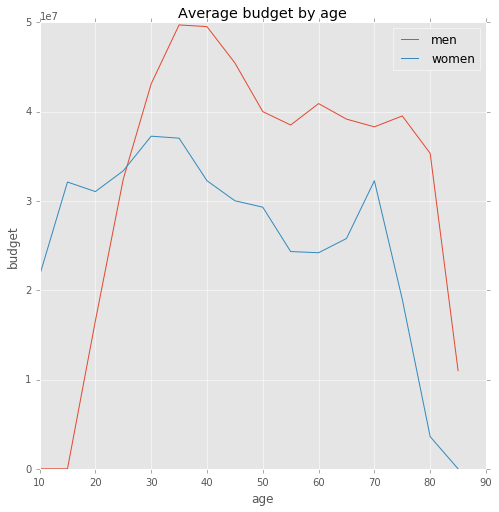

In [49]:
men = np.clip(age_data(gender=['M'], target='budget'), 0, 1.5e8)
women = np.clip(age_data(gender=['F'], target='budget'), 0, 1.5e8)
plt.figure(figsize=(8, 8))
plt.plot(men.index, men.target, label='men')
plt.plot(women.index, women.target, label='women')
plt.xlabel('age')
plt.ylabel('budget')
plt.title('Average budget by age')
plt.legend()


Several things jump out from this:
- The average compensation for mem during their career is approximately stable between the ages of 20 to 45 and 45 to 80
- The average compensation for women is significantly lower than men
- The average compensation for women starts to decay at the age of 40

So, women are paid less, consistently and, moreover, there is a sharp drop when they reach the age of 40. This drop is probably an indication of an age bias with regards to women.

To complete the picture, let us look at the gross:

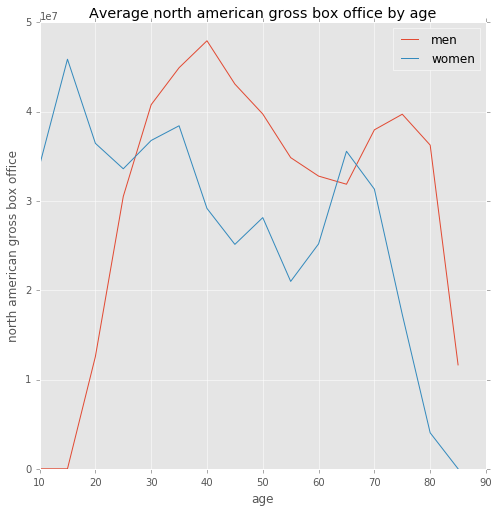

In [50]:
men = np.clip(age_data(gender=['M'], target='gross_usa'), 0, 1.e8)
women = np.clip(age_data(gender=['F'], target='gross_usa'), 0, 1.e8)
plt.figure(figsize=(8, 8))
plt.plot(men.index, men.target, label='men')
plt.plot(women.index, women.target, label='women')
plt.xlabel('age')
plt.ylabel('north american gross box office')
plt.title('Average north american gross box office by age')
plt.legend()

Up until actors are 30, there is a clear advantage to women. Between 30 and 40 men and women are tied, and we get the same drop in women after the age of 35. However, we have a sharp spike between 60 and 70, which we could only speculate about its underlying causes.

If we look at the data a bit differently, namely, we normalize the gross of the movies by their budget, we get an interesting picture:

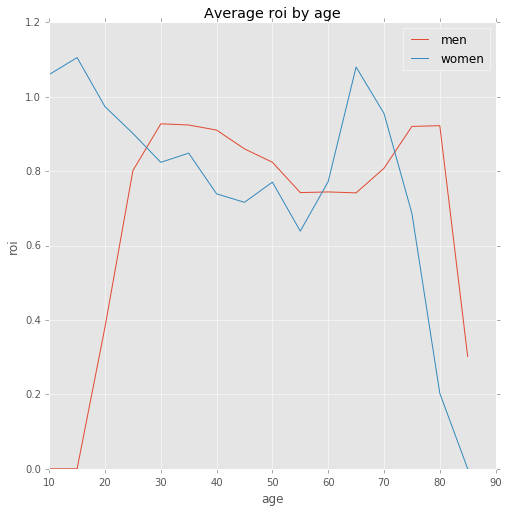

In [51]:
men = age_data(gender=['M'], target='gross_usa/budget')
women = age_data(gender=['F'], target='gross_usa/budget')
plt.figure(figsize=(8, 8))
plt.plot(men.index, men.target, label='men')
plt.plot(women.index, women.target, label='women')
plt.xlabel('age')
plt.ylabel('roi')
plt.title('Average roi by age')
plt.legend()

In terms of profitability, women dominate the playing field up until the age of 30. Between 30 and 45 men and women have approximately the same profitability. Between the ages of 45 to 60, men clearly dominate. There is also a spike for women between 60 and 70, but the last interesting bit is that men can resume their career into their 80 and have no averse effect on their profitability. 

# Conclsions

???